## Functions

In [42]:
## Imports ##
import os
import cv2
import time
import math
import torch
import pickle
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageOps
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms

### Helper functions ###

def generate_boxes_landmarks(img, mtcnn, device):
    all_boxes, all_probs, all_landmarks = mtcnn.detect(torch.Tensor(img).to(device), landmarks=True)
    if all_boxes is None: return [], [], []
    all_boxes = [[int(x) for x in box] for box in all_boxes] 
    all_landmarks = [[[int(x), int(y)] for x, y in point] for point in all_landmarks] 

    boxes, probs, landmarks, centres = [], [], [], []
    threshold = 0.9
    for box, prob, landmark in zip(all_boxes, all_probs, all_landmarks):
            if prob >= threshold:
                boxes.append(box)
                probs.append(prob)
                landmarks.append(landmark)
    # print(f"[{len(boxes)}/{len(all_boxes)}] faces used")
    return boxes, landmarks, probs

def calculate_rotate_angle(left_eye, right_eye):

    if left_eye[1] > right_eye[1]: # right eye higher than left eye
        # print("rotating clockwise")
        direction = -1
        third_point = (right_eye[0], left_eye[1])
    else:
        # print("rotating counter-clockwise")
        direction = 1
        third_point = (left_eye[0], right_eye[1])

    def euclidean_distance(a, b):
        return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    a = euclidean_distance(left_eye, third_point)
    b = euclidean_distance(right_eye, left_eye)
    c = euclidean_distance(right_eye, third_point)
    angle = np.degrees(np.arccos((b*b + c*c - a*a)/(2*b*c)))

    if direction == -1:
        angle = 90 - angle

    rotate_angle = direction * angle
    return rotate_angle

def find_new_bbox_cords(mtcnn, rotated_img, face_centre, device):
    new_boxes, _, _ = generate_boxes_landmarks(rotated_img, mtcnn, device)
    boxes_distances = []
    for new_box in new_boxes:
        centre = [(new_box[0] + new_box[2])//2, (new_box[1] + new_box[3])//2]
        difference = abs(np.array(centre) - np.array(face_centre)).mean()
        boxes_distances.append([difference, new_box])
    if len(boxes_distances) == 0: 
        return []
    boxes_distances.sort(key=lambda x: x[0])
    wanted_box = boxes_distances[0][1]
    return wanted_box

def poisson_blend(paste_image, source_img, box):
    """ Poisson blending using seamlessClone
    blends paste_image into source_image
    """
    src_mask = np.zeros(paste_image.shape, paste_image.dtype)
    height,width = paste_image.shape[:2]

    rectangle = np.array([
        [0, 0], 
        [0, height],
        [width, height],
        [width, 0]], np.int32)
    cv2.fillPoly(src_mask, [rectangle], (255, 255, 255))

    box_centre = [(box[0] + box[2])//2, (box[1] + box[3])//2]
    blended = cv2.seamlessClone(paste_image, source_img, src_mask, box_centre, cv2.NORMAL_CLONE)
    return blended




## Main

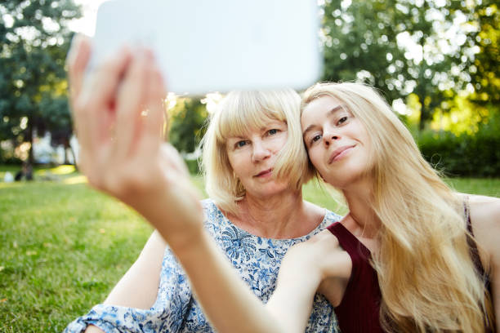

In [43]:
image_filepath = 'media/16070.jpg'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Load MTCNN face detection model
mtcnn = MTCNN(keep_all=True, device=device) #loading face detection model

original_img = cv2.imread(image_filepath)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
display(ImageOps.contain(Image.fromarray(original_img), (500, 500)))

rotate angle: -35.10 degrees
rotate angle: -20.73 degrees


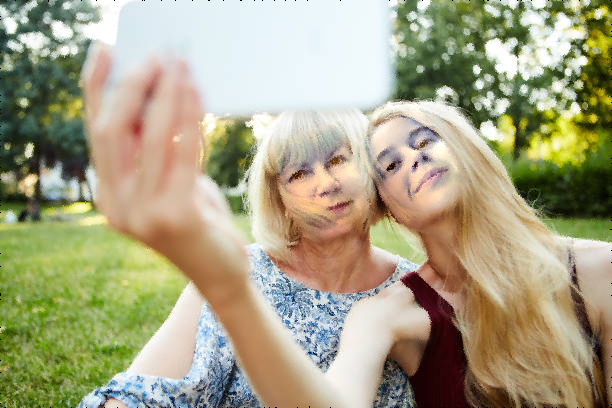

In [47]:
## Looping through each face in the image ##
pad_width = max(original_img.shape[:2])//2

# work with padded image to ensure during rotation the face does not leave the image
original_img_padded = np.zeros([original_img.shape[0]+2*pad_width, original_img.shape[1]+2*pad_width, 3], dtype = original_img.dtype)
original_img_padded[pad_width:-pad_width, pad_width:-pad_width] = original_img.copy()

#finds boxes, landmarks using original image
original_boxes, original_landmarks, original_probs = generate_boxes_landmarks(original_img_padded, mtcnn, device)

for box, landmark in zip(original_boxes, original_landmarks):
    left_eye, right_eye = landmark[0], landmark[1]
    face_centre = [(box[0] + box[2])//2, (box[1] + box[3])//2]
    rotate_angle = calculate_rotate_angle(left_eye, right_eye)
    print(f"rotate angle: {rotate_angle:.2f} degrees")

    rotate_angle = calculate_rotate_angle(left_eye, right_eye)
    rotated_img = np.array(Image.fromarray(original_img_padded).rotate(rotate_angle, center=face_centre, expand=False))
    rotated_box = find_new_bbox_cords(mtcnn, rotated_img, face_centre, device)
    cropped_face = rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]].copy()
    
    #Inpaint face
    inpainted_face = cropped_face[:, ::-1, ::-1].copy()

    #place inpaint face back into original image
    #Poisson blend inpainted face onto rotated face
    # rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]] = inpainted_face.copy() # naive replacement
    rotated_img = poisson_blend(inpainted_face.copy(), rotated_img, rotated_box)

    #rotate back to original orientation and set as base image
    unrotated_img = np.array(Image.fromarray(rotated_img).rotate(-rotate_angle, center=face_centre, expand=False))
    original_img_padded = unrotated_img.copy()

box = original_boxes[0]
# cv2.rectangle(original_img_padded, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
display(Image.fromarray(original_img_padded[pad_width:-pad_width, pad_width:-pad_width]))
